<a href="https://colab.research.google.com/github/HarshSinghgithub/ExpenseTracker/blob/master/Dog_Breed_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"harshpratapsingh23","key":"07db032b96c15aba971b56e1811f5170"}'}

In [10]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset
!unzip -q stanford-dogs-dataset.zip -d Stanford_Dogs_Dataset

 99% 742M/750M [00:10<00:00, 131MB/s]
100% 750M/750M [00:10<00:00, 74.7MB/s]


In [5]:
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import keras
from keras import layers, models
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import cv2
import datetime
import requests
from PIL import Image
from io import BytesIO
import pickle

In [12]:
dir_path = "/content/Stanford_Dogs_Dataset/"
formated_dir_path = "/content/Formated_Dataset/"
annotation_path = os.path.join(dir_path,'annotations/Annotation')
images_path = os.path.join(dir_path,'images/Images')
train_dir = os.path.join(formated_dir_path, 'Train')
valid_dir = os.path.join(formated_dir_path, 'Valid')
test_dir = os.path.join(formated_dir_path, 'Test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [13]:
images_subdir = os.listdir(images_path)

for breed_subdir in images_subdir :
  breed_subdir_path = os.path.join(images_path, breed_subdir)
  breed_name = breed_subdir.split('-', 1)[1]

  train_breed_dir = os.path.join(train_dir, breed_name)
  os.makedirs(train_breed_dir, exist_ok=True)

  valid_breed_dir = os.path.join(valid_dir, breed_name)
  os.makedirs(valid_breed_dir, exist_ok=True)

  test_breed_dir = os.path.join(test_dir, breed_name)
  os.makedirs(test_breed_dir, exist_ok=True)

  image_files = os.listdir(breed_subdir_path)
  l = len(image_files)

  for i in range(250 - l) :
    image = cv2.imread(os.path.join(breed_subdir_path, image_files[i]))
    if image is not None:
      image_float32 = image.astype(np.float32)
      augmented_img = tf.image.stateless_random_brightness(image_float32, max_delta=0.95, seed=(i,0))
      augmented_img = np.array(augmented_img)
      aug_img_path = os.path.join(breed_subdir_path,f'augmented_image_{i}.jpg')
      cv2.imwrite(aug_img_path, augmented_img)
    else :
      print(image_files[i])

  image_files = os.listdir(breed_subdir_path)

  train_images, temp_files = train_test_split(image_files, test_size=0.3, random_state=42)
  valid_images, test_images = train_test_split(temp_files, test_size=0.5, random_state=42)

  for image in train_images :
    src_path = os.path.join(breed_subdir_path, image)
    dest_path = os.path.join(train_breed_dir, image)
    os.makedirs(dest_path, exist_ok=True)
    shutil.move(src_path, dest_path)

  for image in valid_images :
    src_path = os.path.join(breed_subdir_path, image)
    dest_path = os.path.join(valid_breed_dir, image)
    os.makedirs(dest_path, exist_ok=True)
    shutil.move(src_path, dest_path)

  for image in test_images :
    src_path = os.path.join(breed_subdir_path, image)
    dest_path = os.path.join(test_breed_dir, image)
    os.makedirs(dest_path, exist_ok=True)
    shutil.move(src_path, dest_path)

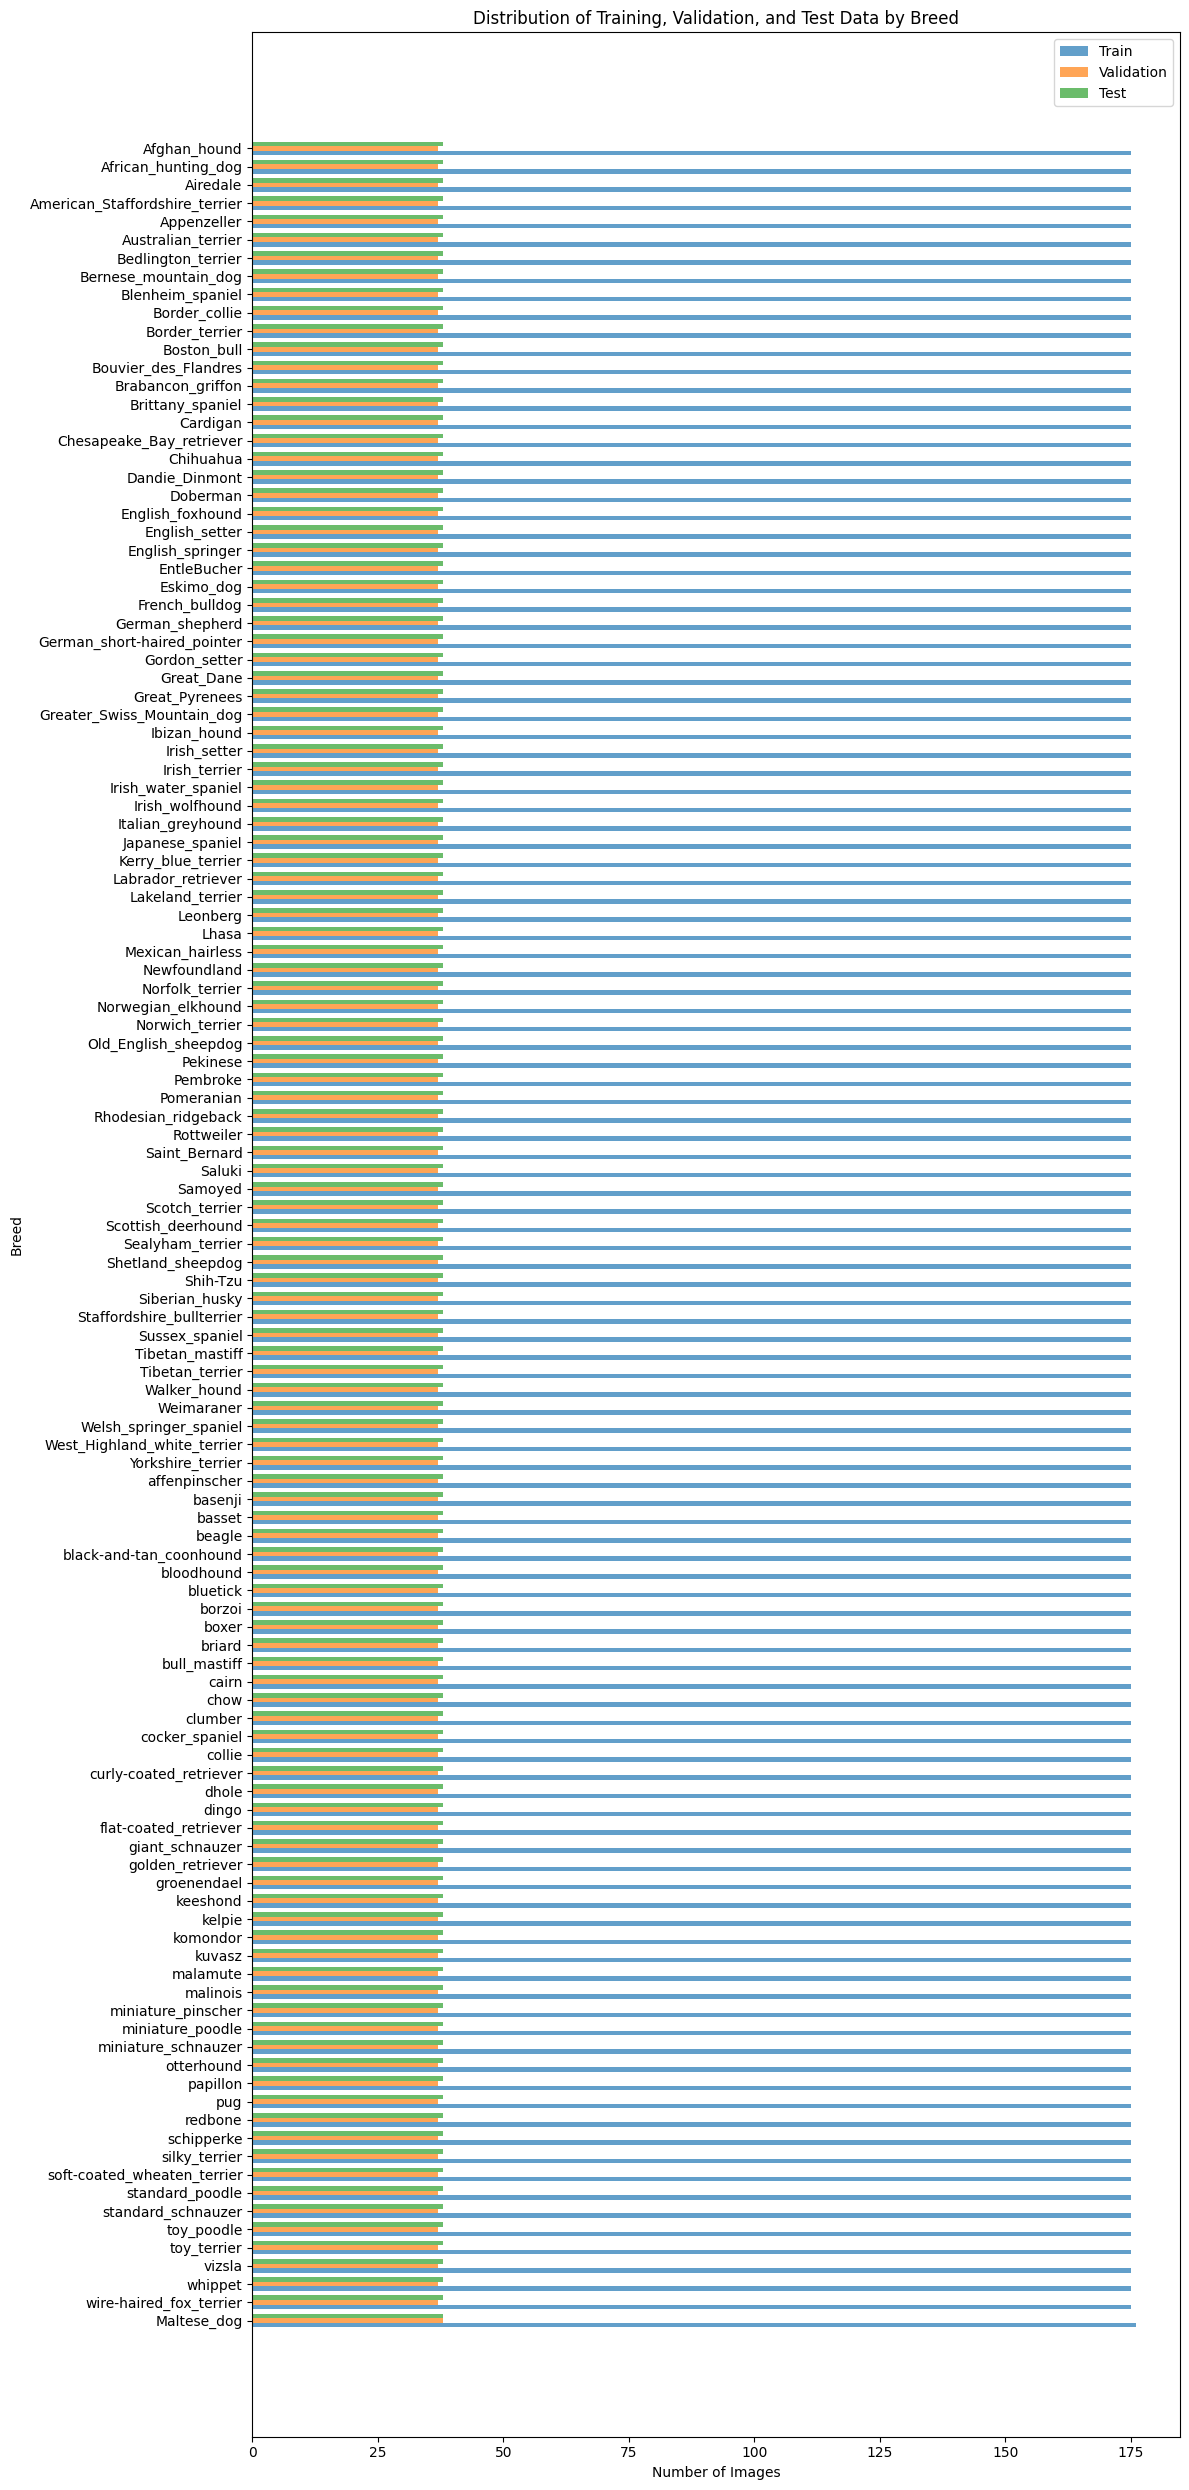

In [14]:
# Breed names and count lists from your existing code
breed_names = os.listdir(train_dir)
train_count = [len(os.listdir(os.path.join(train_dir, breed))) for breed in breed_names]
valid_count = [len(os.listdir(os.path.join(valid_dir, breed))) for breed in breed_names]
test_count = [len(os.listdir(os.path.join(test_dir, breed))) for breed in breed_names]

# Sort breeds by the number of images in the training set (you can adjust this)
sorted_breeds = [breed for _, breed in sorted(zip(train_count, breed_names), reverse=True)]
sorted_train_count = sorted(train_count, reverse=True)
sorted_valid_count = [valid_count[breed_names.index(breed)] for breed in sorted_breeds]
sorted_test_count = [test_count[breed_names.index(breed)] for breed in sorted_breeds]

# Create a horizontal bar chart
plt.figure(figsize=(12, 25))

bar_width = 0.25
index = np.arange(len(sorted_breeds))

plt.barh(index, sorted_train_count, bar_width, label='Train', alpha=0.7)
plt.barh(index + bar_width, sorted_valid_count, bar_width, label='Validation', alpha=0.7)
plt.barh(index + 2 * bar_width, sorted_test_count, bar_width, label='Test', alpha=0.7)

plt.xlabel('Number of Images')
plt.ylabel('Breed')
plt.title('Distribution of Training, Validation, and Test Data by Breed')
plt.yticks(index + bar_width, sorted_breeds)
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
batch_size = 64
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    label_mode='categorical'
)

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    batch_size=batch_size,
    shuffle=False,
    label_mode='categorical'
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    shuffle=False,
    label_mode='categorical'
)


Found 21001 files belonging to 120 classes.
Found 4441 files belonging to 120 classes.
Found 4560 files belonging to 120 classes.


In [16]:
breeds = train_dataset.class_names
label_map = {}

for i, v in enumerate(breeds):
  label_map.update({i:v})

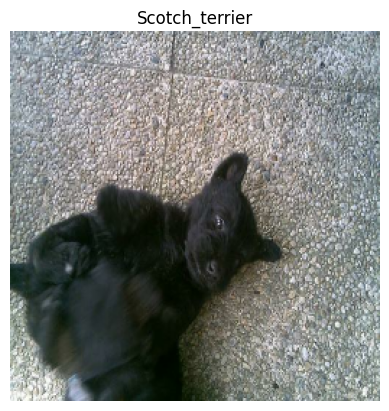

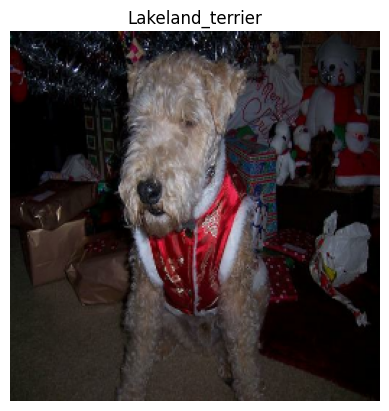

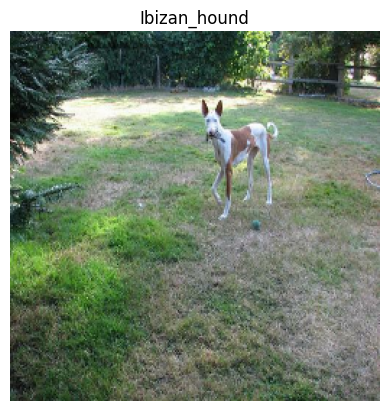

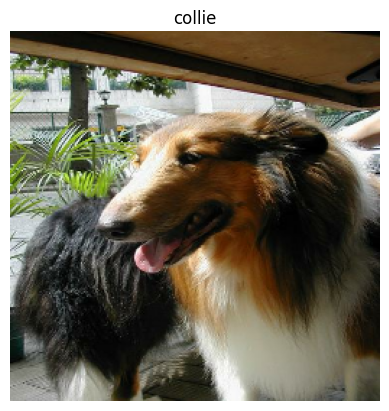

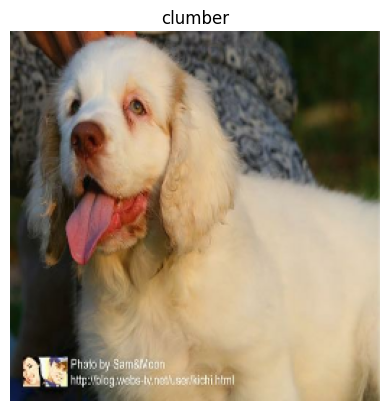

In [ ]:
sample_dataset = train_dataset.take(1)

for image_batch, label_batch in sample_dataset :
  for i in range(5) :
    image = image_batch[i].numpy().astype('uint8')
    label = label_batch[i]
    decoded_label = tf.argmax(label).numpy()

    plt.figure()
    plt.imshow(image)
    plt.title(f'{label_map[decoded_label]}')
    plt.axis('off')
    plt.show()

In [17]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

preprocessing = tf.keras.Sequential([
    layers.Resizing(IMG_HEIGHT, IMG_WIDTH),
    layers.Rescaling(1./255)
])

In [ ]:
inception_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)
inception_model.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
output_layer = tf.keras.Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Dropout(rate=0.4),
    layers.Dense(units=120, activation='softmax')
])

In [ ]:
model = tf.keras.Sequential([
    preprocessing,
    inception_model,
    output_layer
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
saved_model_path = "/content/drive/MyDrive/Dog_Breed_Classification.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = saved_model_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=valid_dataset,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
329/329 [==============================] - ETA: 0s - loss: 1.1800 - accuracy: 0.6988
Epoch 1: val_loss improved from inf to 0.66033, saving model to /content/drive/MyDrive/Dog_Breed_Classification.h5
329/329 [==============================] - 88s 219ms/step - loss: 1.1800 - accuracy: 0.6988 - val_loss: 0.6603 - val_accuracy: 0.8027
Epoch 2/10
328/329 [============================>.] - ETA: 0s - loss: 0.6296 - accuracy: 0.8110
Epoch 2: val_loss improved from 0.66033 to 0.62781, saving model to /content/drive/MyDrive/Dog_Breed_Classification.h5
329/329 [==============================] - 64s 191ms/step - loss: 0.6298 - accuracy: 0.8110 - val_loss: 0.6278 - val_accuracy: 0.8133
Epoch 3/10
328/329 [============================>.] - ETA: 0s - loss: 0.5076 - accuracy: 0.8406
Epoch 3: val_loss improved from 0.62781 to 0.60117, saving model to /content/drive/MyDrive/Dog_Breed_Classification.h5
329/329 [==============================] - 68s 203ms/step - loss: 0.5077 - accuracy: 0.8404

In [21]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test Loss -> {test_loss}')
print(f'Test acc -> {test_acc}')

72/72 [==============================] - 359s 5s/step - loss: 0.2657 - accuracy: 0.9351
Test Loss -> 0.26573753356933594
Test acc -> 0.9350877404212952


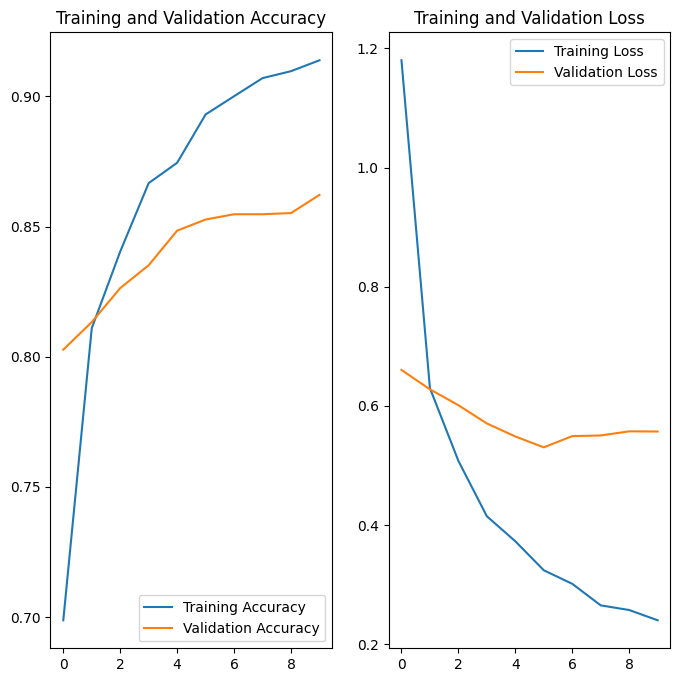

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
for layer in model.layers[:-5]:
    layer.trainable = True

In [ ]:
model.load_weights(saved_model_path)
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=valid_dataset,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
328/329 [============================>.] - ETA: 0s - loss: 0.3290 - accuracy: 0.8895
Epoch 1: val_loss did not improve from 0.53041
329/329 [==============================] - 90s 268ms/step - loss: 0.3289 - accuracy: 0.8896 - val_loss: 0.5904 - val_accuracy: 0.8426
Epoch 2/10
328/329 [============================>.] - ETA: 0s - loss: 0.2886 - accuracy: 0.8992
Epoch 2: val_loss did not improve from 0.53041
329/329 [==============================] - 68s 205ms/step - loss: 0.2885 - accuracy: 0.8991 - val_loss: 0.5959 - val_accuracy: 0.8494
Epoch 3/10
328/329 [============================>.] - ETA: 0s - loss: 0.2654 - accuracy: 0.9091
Epoch 3: val_loss did not improve from 0.53041
329/329 [==============================] - 71s 215ms/step - loss: 0.2656 - accuracy: 0.9090 - val_loss: 0.5851 - val_accuracy: 0.8566
Epoch 4/10
328/329 [============================>.] - ETA: 0s - loss: 0.2473 - accuracy: 0.9134
Epoch 4: val_loss did not improve from 0.53041
329/329 [=================

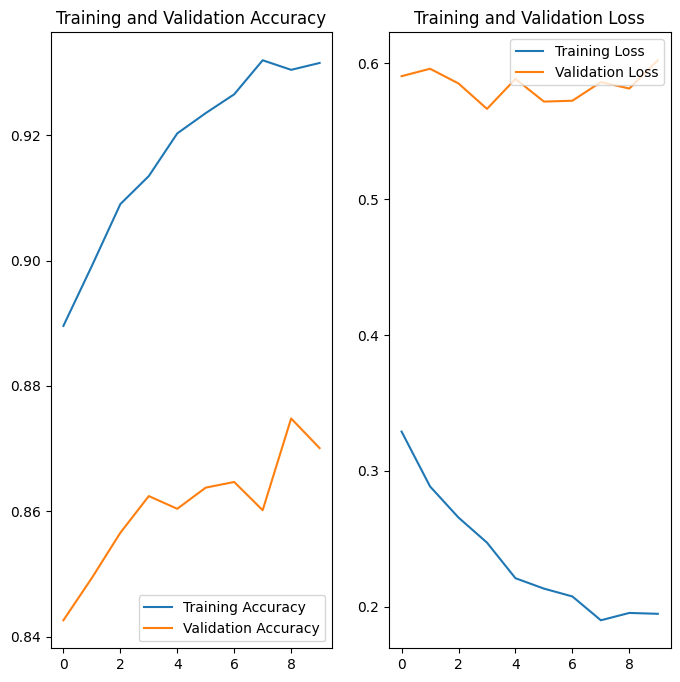

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Dog_Breed_Classifier')

In [ ]:
import pickle

# Save the model to a file using pickle
with open('/content/drive/MyDrive/Pickle_Dog_Breed_Classifier', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 sequential_1 (Sequential)   (None, 120)               245880    
                                                                 
Total params: 22048664 (84.11 MB)
Trainable params: 245880 (960.47 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [18]:
def predict(url, true_label):
    with open('/content/drive/MyDrive/Pickle_Dog_Breed_Classifier', 'rb') as file:
      loaded_model = pickle.load(file)
    response = requests.get(url)
    response_status = response.status_code

    if response_status == 200:
        img = Image.open(BytesIO(response.content))
        img = np.array(img)
        img = np.expand_dims(img, axis=0)

        pred_label = loaded_model.predict(img)
        pred_label = np.argmax(pred_label, axis=1)
        pred_label = label_map[pred_label[0]]

        plt.imshow(img[0])
        plt.title(f'True Label : {true_label} Pred Label : {pred_label}')
        plt.axis('off')
        plt.show()
    else:
        print("Failed to fetch the image.")

1/1 [==============================] - 1s 1s/step


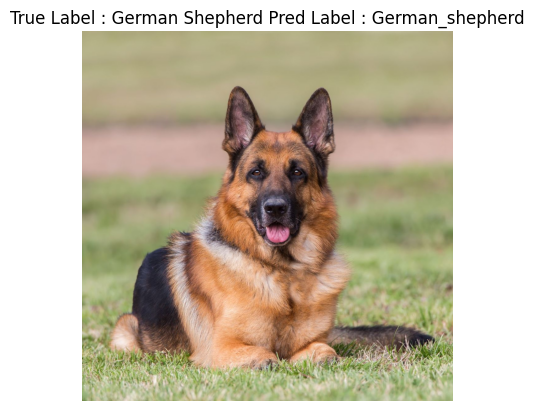

In [19]:
predict("https://hips.hearstapps.com/hmg-prod/images/best-guard-dogs-1650302456.jpeg?crop=0.754xw:1.00xh;0.0651xw,0&resize=1200:*", 'German Shepherd')

1/1 [==============================] - 2s 2s/step


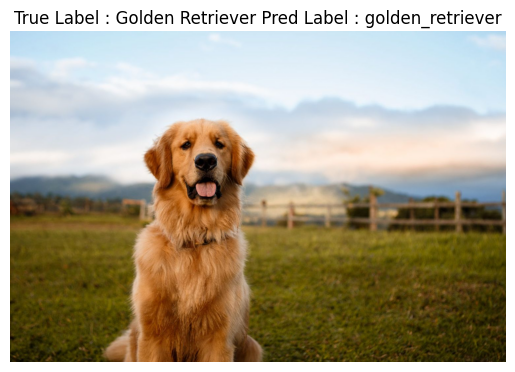

In [ ]:
predict("https://www.southernliving.com/thmb/Rz-dYEhwq_82C5_Y9GLH2ZlEoYw=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/gettyimages-837898820-1-4deae142d4d0403dbb6cb542bfc56934.jpg", 'Golden Retriever')

1/1 [==============================] - 1s 1s/step


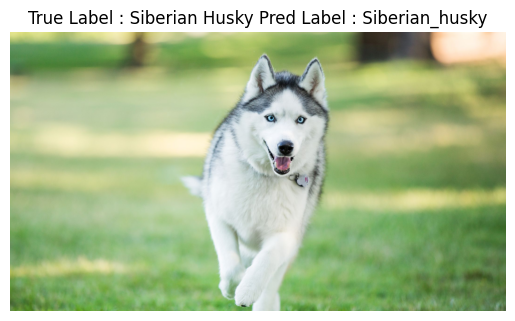

In [ ]:
predict("https://hips.hearstapps.com/hmg-prod/images/wolf-dog-breeds-siberian-husky-1570411330.jpg?crop=1xw:0.84375xh;center,top", "Siberian Husky")